<a href="https://colab.research.google.com/github/lucianosilva-github/compiladores/blob/main/COMPILADORES_AULA_10-SOLUCOES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**COMPILADORES - AULA 10**

**Prof. Luciano Silva**

**OBJETIVOS DA AULA:**

*   Conhecer a análise de longevidade programas escritos em código intermediário
*   Conhecer o processo de alocação de registradores para código intermediário
*   Implementar a análise de longevidade para código intermediário de expressões aritméticas
*   Implementar a alocação de registradores para código intermediário de variáveis


In [1]:
!pip install rply

**TRANSIÇÃO DE CÓDIGO INTERMEDIÁRIO PARA CÓDIGO DO PROCESSADOR-ALVO**

Quando geramos código intermediário, tomamos a liberdade de usar um número infinito de registradores. Na máquina de P-Code podíamos usar um número infinito de posições na pilha de execução do programa.

Porém, quando vamos gerar o código final para um processador-alvo (um Intel 8086, por exemplo), temos que alocar um número finito de registradores. Para calcular esta alocação, dependemos de dois procedimentos:

* **análise de longevidade:** para cada instrução, vamos determinar quais registradores de código intermediário precisam estar ativos naquele momento.

* **alocação de registradores:** com base nos dados da análise de longevidade, vamos criar um grafo de dependências. A partir deste grafo, tentamos realizar uma coloração do grafo com uma quantidade de cores igual ao número de registradores disponíveis. Caso seja possível, a alocação é realizada com as cores utilizadas na coloração.

**ANÁLISE DE LONGEVIDADE (LIVENESS ANALYSIS)**

Na análise de longevidade, precisamos descobrir quais registradores do código intermediário precisam estar "vivos", isto é, não podendo ser sobrescritos, para que o código possa ser gerado sem conflitos de registradores.

Para fazer uma análise de longevidade, para cada instrução, determinamos o conjunto de registradores vivos. Vamos considerar o código intermediário gerado para a instrução Pascal 2*x-60/y. Na coluna da esquerda, temos a instrução em código intermediário e, na direita, o conjunto de longevidade associado (posições na pilha de execução):

<table border=1>
<tr> <th> Código Intermediário<th> Conjunto de Longevidade
<tr> <td> lit 0 2 <td> 0
<tr> <td> lod 0 x  <td> 0 1
<tr> <td> opr 0 4 <td> 0
<tr> <td> lit 0 60 <td> 0 1
<tr> <td> lod 0 y <td> 0 1 2
<tr> <td> opr 0 5 <td> 0 1
<tr> <td> opr 0 3 <td> 0
</table> 


**EXERCÍCIO**

Calcular os conjuntos de longevidade para o código intermediário em P-Code associado à regra **\< expression \>** :


\<prog\> ::= \<var-decls\> \<atrib\>

\<var-decls\> ::= \<var-decl\> 

       | \<var-decl\> \<var-decls\>

\<var-decl\> ::= \<type\> ID ;

\<type\> ::= int | string 

\<atrib\> ::= ID = \<expression\>

\<expression\> ::= ID

      | NUMBER

      | \<expression\> "+" \<expression\>
 
      | \<expression\> "-" \<expression\>
 
      | \<expression\> "*" \<expression\>
 
      | \<expression\> "/" \<expression\>
 
      | "(" <expression> ")"

* Implementação do analisador léxico:





In [2]:
from rply import LexerGenerator

lg = LexerGenerator()

lg.add('NUMBER', r'\d+')
lg.add('PLUS', r'\+')
lg.add('MINUS', r'-')
lg.add('MUL', r'\*')
lg.add('DIV', r'/')
lg.add('OPEN_PARENS', r'\(')
lg.add('CLOSE_PARENS', r'\)')

lg.add('INT', r'int')
lg.add('STRING', r'string')
lg.add('ID', r'[a-zA-z][a-zA-z0-9]*')
lg.add('EQUALS', r'=')
lg.add('SEMICOL', r';')

lg.ignore('\s+')

lexer = lg.build()

* Classes dos nós da árvore sintática, já com o método accept para receber os visitors:

In [3]:
from rply.token import BaseBox

class Prog(BaseBox):
    def __init__(self, decls,atrib):
        self.decls = decls
        self.atrib = atrib

    def accept(self, visitor):
        visitor.visit_prog(self)

class VarDecls(BaseBox):
    def __init__(self, decl,decls):
        self.decl = decl
        self.decls = decls

    def accept(self, visitor):
        visitor.visit_vardecls(self)

class VarDecl(BaseBox):
    def __init__(self, id,tp):
        self.id = id
        self.tp = tp
        

    def accept(self, visitor):
        visitor.visit_vardecl(self)

class Atrib(BaseBox):
    def __init__(self, id,expr):
        self.id = id
        self.expr = expr

    def accept(self, visitor):
        visitor.visit_atrib(self)

class Expr(BaseBox):
    def accept(self, visitor):
        method_name = 'visit_{}'.format(self.__class__.__name__.lower())
        visit = getattr(visitor, method_name)
        visit(self)

class Id(Expr):
    def __init__(self, value):
        self.value = value

class Number(Expr):
    def __init__(self, value):
        self.value = value


class BinaryOp(Expr):
    def __init__(self, left, right):
        self.left = left
        self.right = right

class Add(BinaryOp):
  pass
    

class Sub(BinaryOp):
  pass
   

class Mul(BinaryOp):
  pass
    

class Div(BinaryOp):
  pass
    

* Implementação do analisador sintático:

In [4]:
from rply import ParserGenerator

pg = ParserGenerator(
    # A list of all token names, accepted by the lexer.
    ['NUMBER', 'OPEN_PARENS', 'CLOSE_PARENS',
     'PLUS', 'MINUS', 'MUL', 'DIV', 'INT', 'STRING', 'ID','SEMICOL',
     'EQUALS'
    ],
    # A list of precedence rules with ascending precedence, to
    # disambiguate ambiguous production rules.
    precedence=[
        ('left', ['PLUS', 'MINUS']),
        ('left', ['MUL', 'DIV'])    
    ]
)

@pg.production('prog : vardecls atrib')
def prog(p):
    return Prog(p[0],p[1])

@pg.production('vardecls : vardecl')
def expression_vardeclsOne(p):
    return VarDecls(p[0],None) 

@pg.production('vardecls : vardecl vardecls')
def vardecls(p):
    return VarDecls(p[0],p[1])

@pg.production('vardecl : STRING ID SEMICOL')
def expression_vardeclstring(p):
    return VarDecl(p[1].getstr(), p[0].getstr())

@pg.production('vardecl : INT ID SEMICOL')
def expression_vardeclint(p):
    return VarDecl(p[1].getstr(), p[0].getstr())

@pg.production('atrib : ID EQUALS expression')
def atrib(p):
    return Atrib(p[0].getstr(),p[2])


@pg.production('expression : ID')
def expression_id(p):
    return Id(p[0].getstr())

@pg.production('expression : NUMBER')
def expression_number(p):
    return Number(int(p[0].getstr()))

@pg.production('expression : OPEN_PARENS expression CLOSE_PARENS')
def expression_parens(p):
    return p[1]

@pg.production('expression : expression PLUS expression')
@pg.production('expression : expression MINUS expression')
@pg.production('expression : expression MUL expression')
@pg.production('expression : expression DIV expression')
def expression_binop(p):
    left = p[0]
    right = p[2]
    if p[1].gettokentype() == 'PLUS':
        return Add(left, right)
    elif p[1].gettokentype() == 'MINUS':
        return Sub(left, right)
    elif p[1].gettokentype() == 'MUL':
        return Mul(left, right)
    elif p[1].gettokentype() == 'DIV':
        return Div(left, right)
    else:
        raise AssertionError('Oops, this should not be possible!')

parser = pg.build()

* Visitor para montar a tabela de símbolos:

In [5]:
ST={}

class Visitor(object):
  pass

class SymbolTable(Visitor):
    def visit_prog(self, prog):
        prog.decls.accept(self)
        
    def visit_vardecls(self, d):
        d.decl.accept(self)
        if d.decls!=None:
          d.decls.accept(self)

    def visit_vardecl(self, d):
        ST[d.id]=d.tp
        

* Visitor para decoração da árvore: 

In [6]:
class Decorator(Visitor):

    def visit_prog(self, i):
        i.atrib.accept(self)

    def visit_atrib(self, i):
        if i.id in ST:
          i.id_decor_type=ST[i.id]
        else:
          raise AssertionError('id not declared')
        i.expr.accept(self)
        i.expr_decor_type=i.expr.decor_type

    def visit_id(self, i):
        if i.value in ST:
          i.decor_type=ST[i.value]
        else:
          raise AssertionError('id not declared')


    def visit_number(self, i):
        i.decor_type="int"
        

    def visit_add(self, a):
        a.left.accept(self)
        a.right.accept(self)
        if a.left.decor_type=="int" and a.right.decor_type=="int":
          a.decor_type="int"
          

    def visit_sub(self, a):
        a.left.accept(self)
        a.right.accept(self)
        if a.left.decor_type=="int" and a.right.decor_type=="int":
          a.decor_type="int"

    def visit_mul(self, a):
        a.left.accept(self)
        a.right.accept(self)
        if a.left.decor_type=="int" and a.right.decor_type=="int":
          a.decor_type="int"

    def visit_div(self, a):
        a.left.accept(self)
        a.right.accept(self)
        if a.left.decor_type=="int" and a.right.decor_type=="int":
          a.decor_type="int"

* Visitor para verificação de tipos:

In [7]:
class TypeVerifier(Visitor):

    def visit_prog(self, i):
        i.atrib.accept(self)

    def visit_atrib(self, i):
        if i.id_decor_type!=i.expr_decor_type:
          raise AssertionError('type error')

    def visit_add(self, a):
        if a.left.decor_type != a.right.decor_type:
          raise AssertionError('type error')
          

    def visit_sub(self, a):
        if a.left.decor_type != a.right.decor_type:
          raise AssertionError('type error')

    def visit_mul(self, a):
        if a.left.decor_type != a.right.decor_type:
          raise AssertionError('type error')

    def visit_div(self, a):
        if a.left.decor_type != a.right.decor_type:
          raise AssertionError('type error')

In [28]:
class IntermediateCode(Visitor):

  
  def __init__(self):
    self.ic=[] #lista com código intermediário

  def visit_prog(self, i):
    i.atrib.accept(self)
    
  def visit_atrib(self, i):
    i.expr.accept(self)
        

  def visit_id(self, i):
    self.ic.append("lod 0 "+i.value)


  def visit_number(self, i):
    self.ic.append("lit 0 "+str(i.value))
        

  def visit_add(self, a):
    a.left.accept(self)
    a.right.accept(self)
    self.ic.append("opr 0 2")
          

  def visit_sub(self, a):
    a.left.accept(self)
    a.right.accept(self)
    self.ic.append("opr 0 3")

  def visit_mul(self, a):
    a.left.accept(self)
    a.right.accept(self)
    self.ic.append("opr 0 4")

  def visit_div(self, a):
    a.left.accept(self)
    a.right.accept(self)
    self.ic.append("opr 0 5")

In [33]:
arvore=parser.parse(lexer.lex('int x;int y;int z;z=2*x-60/y'))
arvore.accept(SymbolTable())
arvore.accept(Decorator())
arvore.accept(TypeVerifier())
icvisitor=IntermediateCode()
arvore.accept(icvisitor)
ic=icvisitor.ic   #código intermediário gerado
print(ic)

['lit 0 2', 'lod 0 x', 'opr 0 4', 'lit 0 60', 'lod 0 y', 'opr 0 5', 'opr 0 3']


In [37]:
#implemente sua solução aqui. Sua saída deve ser algo do tipo:
#[('lit 0 2' ,{0}    ),
# ('lod 0 x' ,{0,1}  ), 
# ('opr 0 4' ,{0}    ), 
# ('lit 0 60',{0,1}  ), 
# ('lod 0 y' ,{0,1,2}), 
# ('opr 0 5' ,{0,1}  ), 
# ('opr 0 3' ,{0}    )]

def liveness_analysis(ic):
  ic_la=[]
  
    
  return ic_la

print(liveness_analysis(ic))

[]


In [62]:
#implemente sua solução aqui. Sua saída deve ser algo do tipo:
#[('lit 0 2' ,{0}    ),
# ('lod 0 x' ,{0,1}  ), 
# ('opr 0 4' ,{0}    ), 
# ('lit 0 60',{0,1}  ), 
# ('lod 0 y' ,{0,1,2}), 
# ('opr 0 5' ,{0,1}  ), 
# ('opr 0 3' ,{0}    )]

def liveness_analysis(ic):
  ic_la=[]
  la=set({})
  t=0
  for i in ic:
    if i.startswith("lit") or i.startswith("lod"):
      la=la.union(set({t}))
      t=t+1
    elif i.startswith("opr"):
          la.remove(t-1)
          t=t-1
    ic_la.append((i,la.copy()))
  return ic_la

ic_la=liveness_analysis(ic)
for p in ic_la:
  print(p,"\n")


('lit 0 2', {0}) 

('lod 0 x', {0, 1}) 

('opr 0 4', {0}) 

('lit 0 60', {0, 1}) 

('lod 0 y', {0, 1, 2}) 

('opr 0 5', {0, 1}) 

('opr 0 3', {0}) 



**ALOCAÇÃO DE REGISTRADORES**

Para realizar a alocação de registradores, vamos utilizar os dados da análise de longevidade. Para cada conjunto de longevidade, vamos criar vértices e arestas para formar um **grafo de dependências**.

Seja S um conjunto de longevidade. Para cada i dentro do conjunto, criamos um vértice com o rótulo de i. Para cada par i e j dentro de S, criamos uma aresta e já percebemos que i e j não podem estar dentro do mesmo registrador.


<table border=1>
<tr> <th> Código Intermediário<th> Conjunto de Longevidade <th> Aresta (arestas)
<tr> <td> lit 0 2 <td> 0 <td>
<tr> <td> lod 0 x  <td> 0 1 <td> 0-1
<tr> <td> opr 0 4 <td> 0 <td>
<tr> <td> lit 0 60 <td> 0 1 <td> 0-1
<tr> <td> lod 0 y <td> 0 1 2 <td> 0-1, 0-2 e 1-2
<tr> <td> opr 0 5 <td> 0 1 <td> 0-1
<tr> <td> opr 0 3 <td> 0
</table> 

Vamos, agora, percorrer os conjuntos de longevidade para construir nosso grafo de dependências:




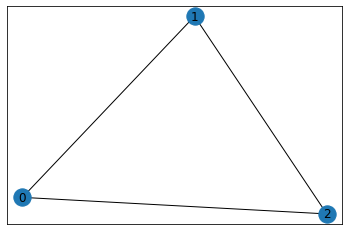

In [68]:
import networkx as nx
import matplotlib.pyplot as plt
import itertools
   
  
class GraphVisualization:
   
    def __init__(self):
          
        # visual is a list which stores all 
        # the set of edges that constitutes a
        # graph
        self.visual = []
          
    # addEdge function inputs the vertices of an
    # edge and appends it to the visual list
    def addEdge(self, a, b):
        temp = [a, b]
        self.visual.append(temp)
          
    # In visualize function G is an object of
    # class Graph given by networkx G.add_edges_from(visual)
    # creates a graph with a given list
    # nx.draw_networkx(G) - plots the graph
    # plt.show() - displays the graph
    def visualize(self):
        G = nx.Graph()
        G.add_edges_from(self.visual)
        nx.draw_networkx(G)
        plt.show()
  
G = GraphVisualization()

for (instr,live) in ic_la:
  edges = itertools.combinations(live, 2)
  for (a,b) in edges:
    G.addEdge(a,b)
G.visualize()

Observe que este grafo nos diz que que as posições 0, 1 e 2 não podem estar no mesmo local, ou seja, vamos precisar de 3 locais. Observe, também, que são necessárias (no mínimo) 3 cores para colorir os vértices deste grafo.

Assim, recaímos num problema de **coloração de grafos**. Para saber o número de registradores, calculamos a colocação mínima do grafo de dependências. No caso do grafo acima, a coloração mínima tem 3 cores.

Para o processador Intel 8086, poderíamos fazer as seguintes alocações: 0--> registrador AX; 1 --> registrador BX e 2 --> registrador CX.

Com esta alocação, o código final ficaria como:

<table border=1>
<tr> <th> Código Intermediário<th> Conjunto de Longevidade <th> Aresta (arestas) <th> Código Assembly 8086
<tr> <td> lit 0 2 <td> 0 <td> <td> MOV AX, 2
<tr> <td> lod 0 x  <td> 0 1 <td> 0-1 <td> MOV BX, 1
<tr> <td> opr 0 4 <td> 0 <td> <td> MUL AX,BX
<tr> <td> lit 0 60 <td> 0 1 <td> 0-1 <td> MOV BX,60
<tr> <td> lod 0 y <td> 0 1 2 <td> 0-1 0-2 1-2<td> MOV CX, Y
<tr> <td> opr 0 5 <td> 0 1 <td>0-1 <td> DIV BX,CX
<tr> <td> opr 0 3 <td> 0 <td> <td> SUB AX,BX
</table> 



**ATIVIDADE EAD**

Dada a estrutura de grafos G acima, implemente um método para calcular o número mínimo de cores para colorir os vértices de G.



In [ ]:
#Implemente sua solução aqui